In [15]:
%pylab inline
import psycopg2
ASOS = psycopg2.connect(database='asos', host='mesonet.agron.iastate.edu', user='nobody')
cursor = ASOS.cursor()

cursor.execute("""
WITH dsm as (
 SELECT valid, to_char(valid + '10 minutes'::interval, 'YYYYMMDDHH24') as v, mslp, sknt from alldata where station = 'DSM' and mslp > 0 and sknt >= 0
 ), 
 dvn as (
 SELECT to_char(valid + '10 minutes'::interval, 'YYYYMMDDHH24') as v, mslp, sknt from alldata where station = 'DVN' and mslp > 0 and sknt >= 0
 ),
 mcw as (
 SELECT to_char(valid + '10 minutes'::interval, 'YYYYMMDDHH24') as v, mslp, sknt from alldata where station = 'MCW' and mslp > 0 and sknt >= 0
 ),
 oma as (
 SELECT to_char(valid + '10 minutes'::interval, 'YYYYMMDDHH24') as v, mslp, sknt from alldata where station = 'OMA' and mslp > 0 and sknt >= 0
 ),
 lwd as (
 SELECT to_char(valid + '10 minutes'::interval, 'YYYYMMDDHH24') as v, mslp, sknt from alldata where station = 'LWD' and mslp > 0 and sknt >= 0
 )
 
SELECT dsm.sknt, greatest(dvn.mslp, mcw.mslp, oma.mslp, lwd.mslp) - 
least(dvn.mslp, mcw.mslp, oma.mslp, lwd.mslp) from dsm, dvn, mcw, oma, lwd
WHERE dsm.v = dvn.v and dvn.v = mcw.v and mcw.v = oma.v and
oma.v = lwd.v and extract(month from dsm.valid) in (12,1,2) and dsm.sknt >= 5

""")
gradient = []
wind = []
for row in cursor:
    wind.append( row[0] * 1.15)
    gradient.append( row[1] )

(20, 30) [0.0, 30.0, 40.0, 0.0] 268.0


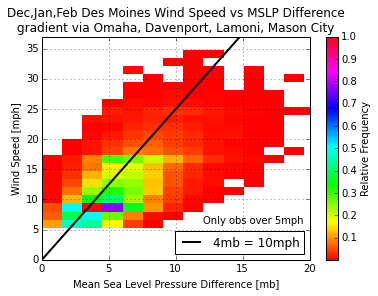

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import matplotlib.cm as cm

H, xedges, yedges = np.histogram2d(gradient, wind, bins=(20,30), range=[[0,30],[0,40]])
extent = [xedges[0], xedges[-1], yedges[-1], yedges[0]]
H = ma.array(H )
H.mask = numpy.where( H < 3, True, False)

print np.shape(H), extent, H[5,10]
#H[5,10] = 10000

(fig, ax) = plt.subplots(1,1)
#ax.scatter(gradient, wind)
res = ax.imshow(H.T / np.max(H),extent=extent, aspect='auto', interpolation='nearest',
                cmap=cm.get_cmap('hsv'))
fig.colorbar(res, label='Relative Frequency')
ax.set_ylim(0,37)
ax.set_xlim(0,20)
ax.set_ylabel("Wind Speed [mph]")
ax.set_xlabel("Mean Sea Level Pressure Difference [mb]") 
ax.plot(range(0,28,4),range(0,70,10), color='k', lw=2, label='4mb = 10mph')
ax.text(12,6, "Only obs over 5mph")
ax.legend(loc=4)
ax.set_title("Dec,Jan,Feb Des Moines Wind Speed vs MSLP Difference\ngradient via Omaha, Davenport, Lamoni, Mason City")
ax.grid(True)

In [51]:
fig.savefig('test.png')
